## <p align="center"><b>Estimating House Prices for a Real Estate Company Using Advanced ML Techniques</b></p>


# Section 1: Business Understanding

---

### Problem Statement :  
A **real estate company** is seeking to **accurately estimate house prices** in order to improve its **pricing strategies** and gain a competitive edge in the market.

---

### Objective :  
Build a **regression model** to predict `MEDV` *(Median House Price)* using various features, including:

- Crime rate  
- Number of rooms  
- Neighborhood economic status

---

### Success Metrics :

| Metric | Target Value | Goal               |
|--------|---------------|--------------------|
| RMSE   | Less than 3.0 | Lower is better    |
| R²     | Greater than 0.85 | Higher is better |

---


# **Dataset Description:**

## Boston Housing Dataset – Quick Description

The **Boston Housing** dataset is a classic dataset used to predict housing prices in the Boston area using features related to crime rate, number of rooms, accessibility to highways, and more.

- **Number of Instances**: 506
- **Features**: 13 predictors + 1 target (`MEDV`)
- **Target Variable**: `MEDV` – Median value of owner-occupied homes in $1000s

### Main Features

| Feature  | Description |
|----------|-------------|
| CRIM     | Crime rate per capita |
| ZN       | Proportion of residential land zoned for large lots |
| INDUS    | Non-retail business acres per town |
| CHAS     | Charles River dummy variable (1 if near river) |
| NOX      | Nitric oxides concentration |
| RM       | Average number of rooms |
| AGE      | % of units built before 1940 |
| DIS      | Distance to employment centers |
| RAD      | Access to radial highways |
| TAX      | Property tax rate |
| PTRATIO  | Pupil-teacher ratio |
| B        | Calculated racial demographic feature |
| LSTAT    | % lower status of the population |

For more details: [Boston Housing on Kaggle](https://www.kaggle.com/c/boston-housing)


---

## Importing Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import xgboost as xgb

from lightgbm import LGBMRegressor
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


### 1. Load the dataset and show the first few rows
We start by reading the CSV file and displaying the first 5 rows to get an overview of the data.

In [2]:
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### 2. Show basic info about the dataset
This includes column names, data types, and whether there are any missing values.

In [3]:
df.shape

(506, 14)

In [4]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [5]:
df.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
MEDV        float64
dtype: object

###  Encoding Categorical Variables

The following lines convert the categorical columns `CHAS` and `RAD` into numerical format using `.cat.codes`, which assigns a unique integer code to each category:



In [6]:
df['CHAS'] = df['CHAS'].cat.codes.astype(int)
df['RAD'] = df['RAD'].cat.codes.astype(int)

## check

In [7]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int32
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int32
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int32  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int32  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int32(2)
memory usage: 51.5 KB


In [9]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,3.723320,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,1.898027,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,0.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,2.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,4.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,5.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,8.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [10]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

###  Visualizing Feature Distributions

The following code generates histograms for **all numerical columns** in the DataFrame to explore their distributions:

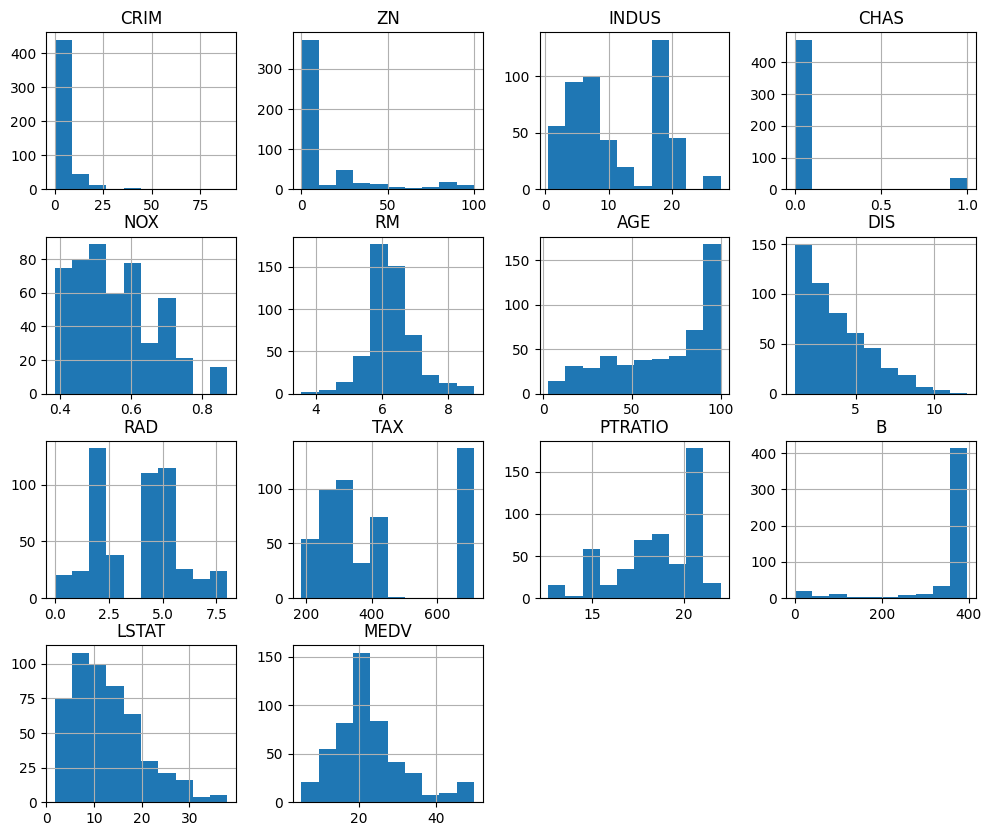

In [11]:
df.hist(figsize=(12, 10))
plt.show()

###  Checking Skewness of Features

This code calculates and prints the **skewness** of each column in the DataFrame:







In [12]:
for column in df.columns:
    skewness = df[column].skew()
    print(f"{column}: {skewness}")


CRIM: 5.223148798243851
ZN: 2.2256663227354307
INDUS: 0.29502156787351164
CHAS: 3.405904172058746
NOX: 0.7293079225348787
RM: 0.40361213328874385
AGE: -0.5989626398812962
DIS: 1.0117805793009007
RAD: 0.23747960872847515
TAX: 0.669955941795016
PTRATIO: -0.8023249268537809
B: -2.8903737121414492
LSTAT: 0.9064600935915367
MEDV: 1.1080984082549072


###  Skewness Analysis Summary

####  Columns with **High Skewness** (|skew| ≥ 1)

| Column | Skewness |
|--------|----------|
| CRIM   | 5.22     |
| ZN     | 2.23     |
| CHAS   | 3.41     |
| DIS    | 1.01     |
| MEDV   | 1.11     |
| B      | -2.89    |

These features have significant skewness and may benefit from transformations like `log`, `sqrt`, or `Box-Cox`.

---

####  Columns with **Moderate Skewness** (0.5 ≤ |skew| < 1)

| Column | Skewness |
|--------|----------|
| NOX    | 0.73     |
| TAX    | 0.67     |
| LSTAT  | 0.91     |

These features show moderate skewness and might be considered for mild transformation based on model performance.

---


###  Log Transformation for Skewed Features

The following code applies a **log transformation** (`log1p`) to reduce skewness in selected features and log1p(x) = log(1 + x), handles 0 safely



In [13]:
for col in ['CRIM', 'ZN', 'DIS', 'MEDV', 'B', 'NOX', 'TAX', 'LSTAT']:
    df[col] = np.log1p(df[col])  # log1p(x) = log(1 + x), handles 0 safely

## check

In [14]:
for column in df.columns:
    skewness = df[column].skew()
    print(f"{column}: {skewness}")


CRIM: 1.2692005882725572
ZN: 1.1934513868588792
INDUS: 0.29502156787351164
CHAS: 3.405904172058746
NOX: 0.5843471124349944
RM: 0.40361213328874385
AGE: -0.5989626398812962
DIS: 0.33156144277059646
RAD: 0.23747960872847515
TAX: 0.33175311836129
PTRATIO: -0.8023249268537809
B: -4.459061270804062
LSTAT: -0.18719503273600827
MEDV: -0.2412435236076337


### violinplot is skewness wit boxplot

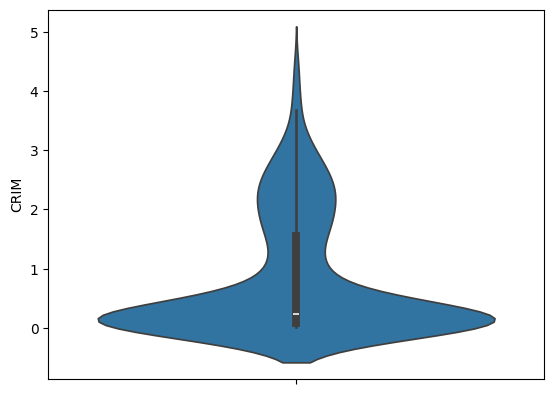

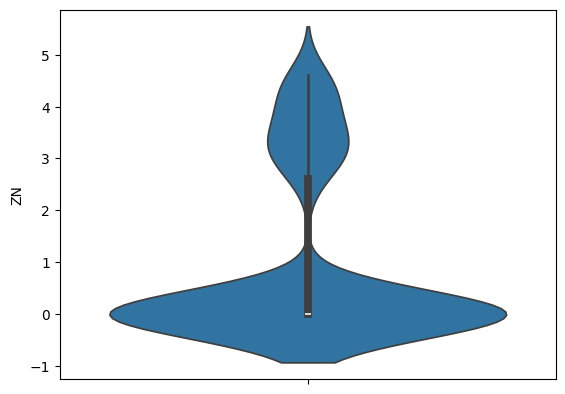

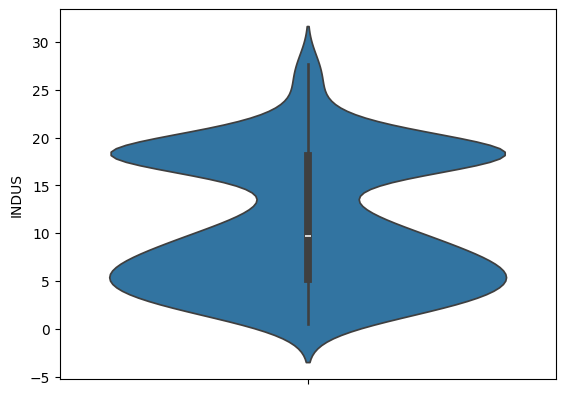

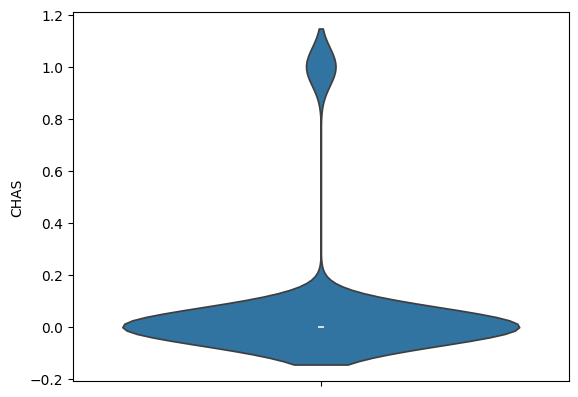

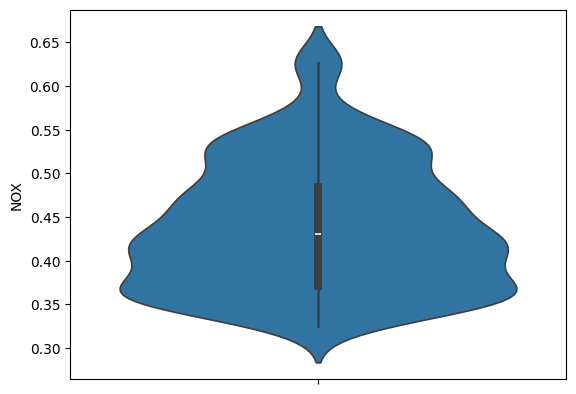

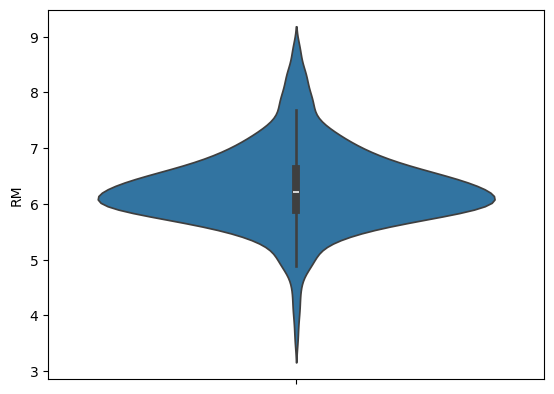

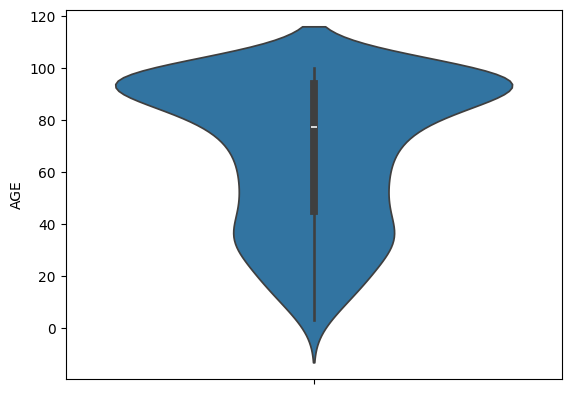

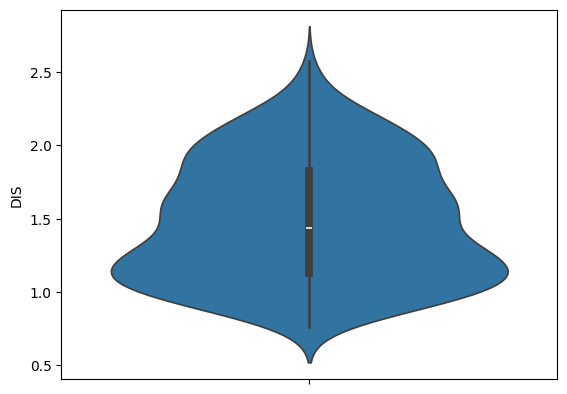

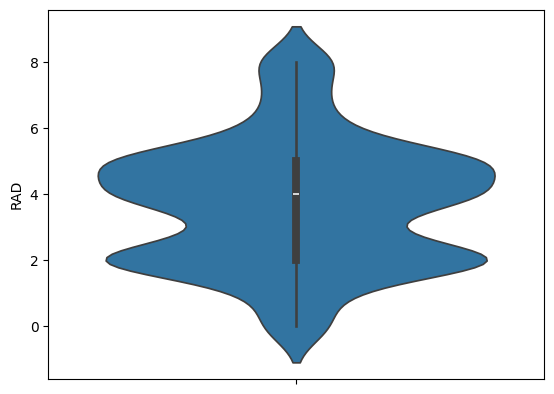

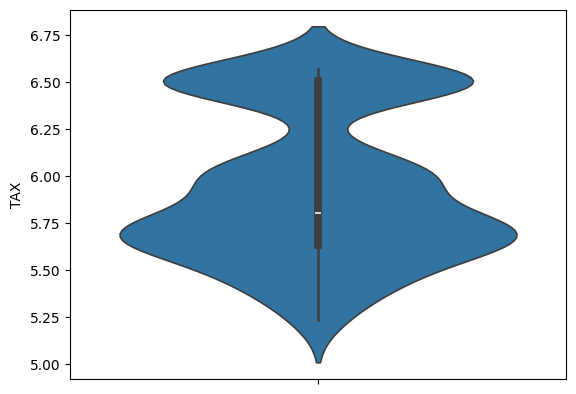

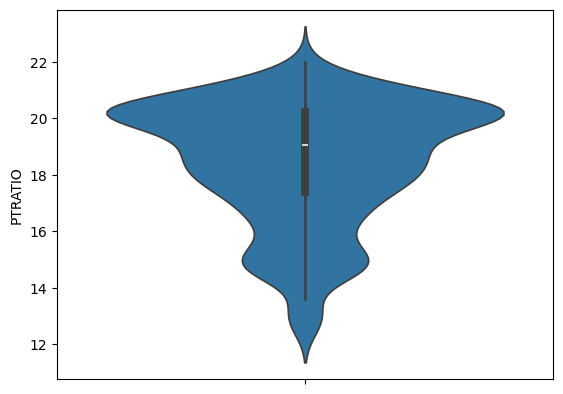

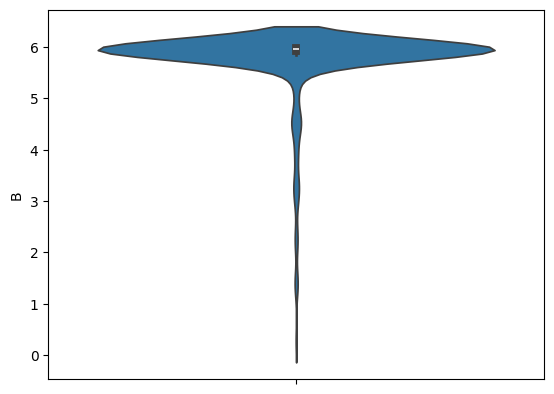

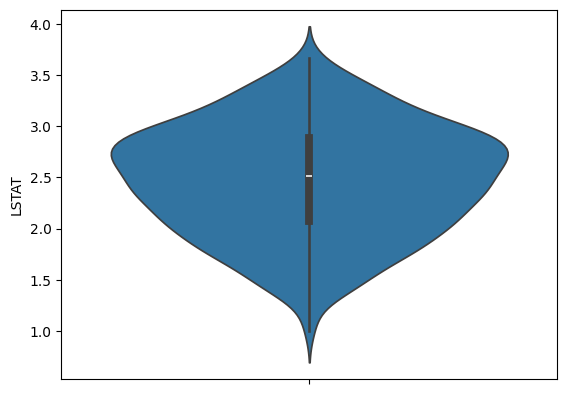

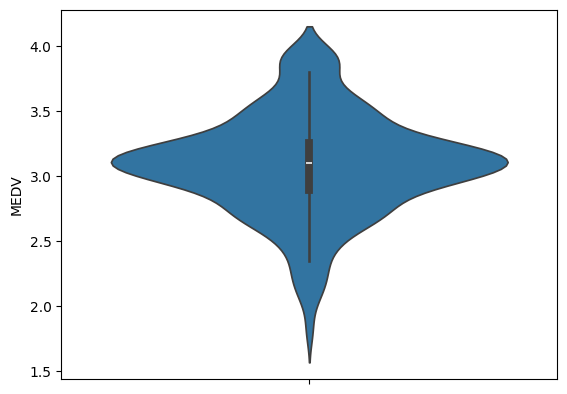

In [15]:
for column in df:
    sns.violinplot(df[column])
    plt.show()

### Feature Correlation Matrix

A heatmap was used to visualize the correlation between all numerical features in the dataset.

- The color gradient shows the strength of correlation:  
  - Dark red = strong positive correlation  
  - Blue = strong negative correlation
- Correlation values are displayed within each cell for clarity.
- This helps in:
  - Identifying multicollinearity between features
  - Spotting features most correlated with `MEDV` (house price)

This step guides better feature selection and model optimization.


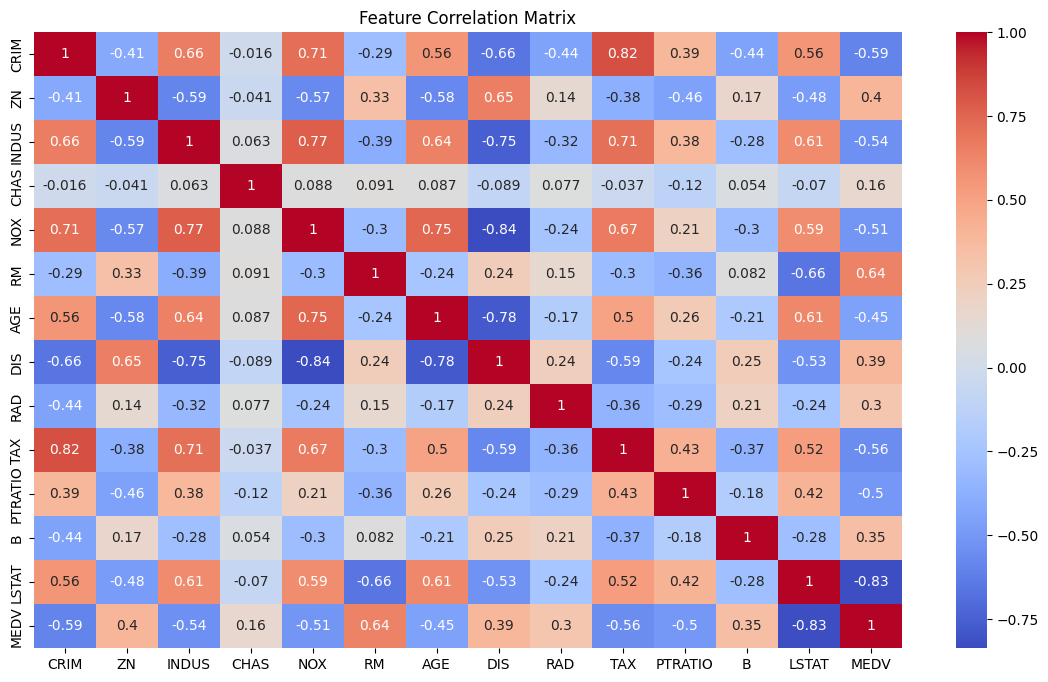

In [16]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

### Handling Duplicates

In [17]:
df.duplicated().sum()

0

###  Boxplot for Each Column

The following loop creates a **boxplot** for every column in the DataFrame to detect outliers and understand the data distribution:


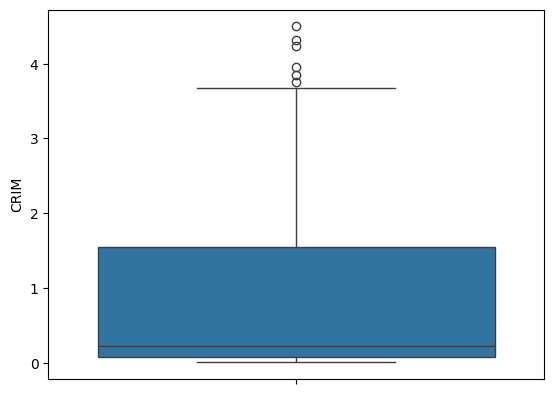

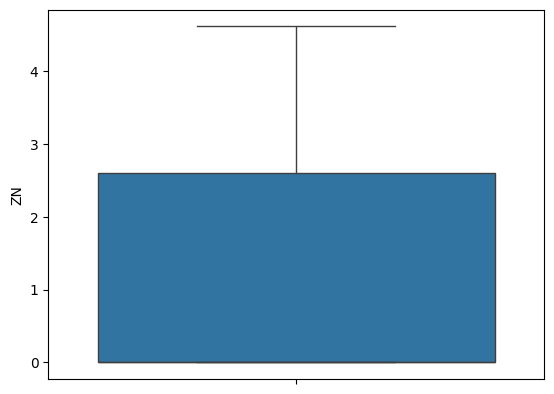

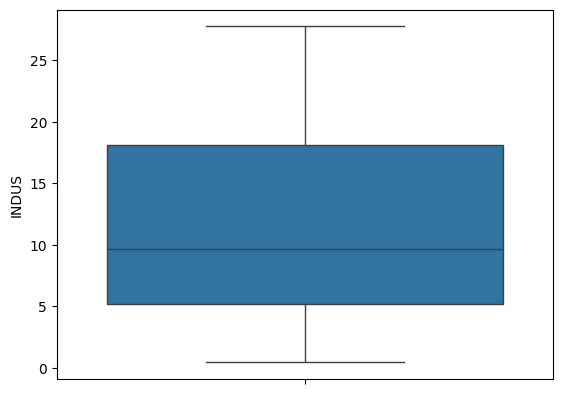

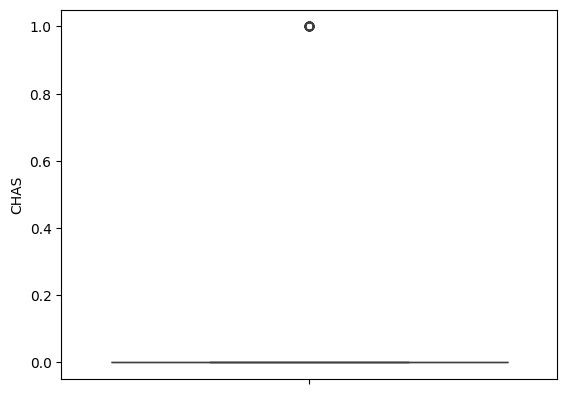

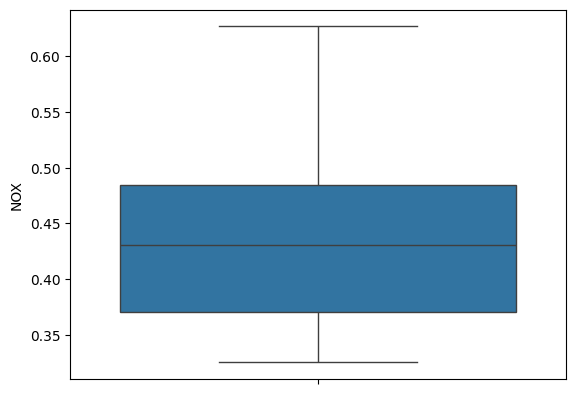

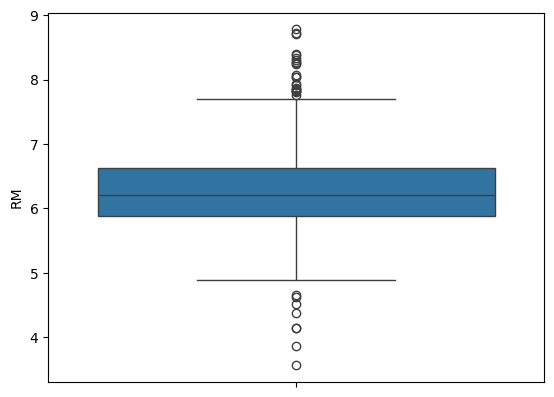

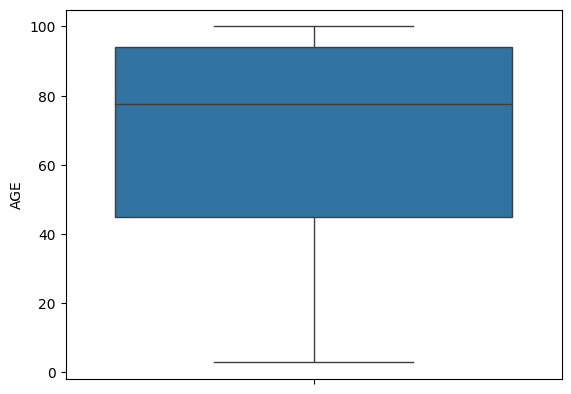

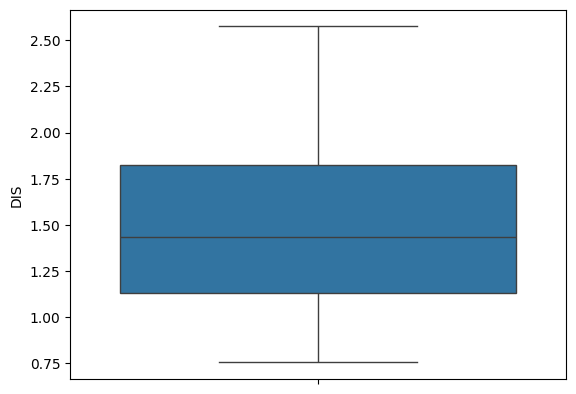

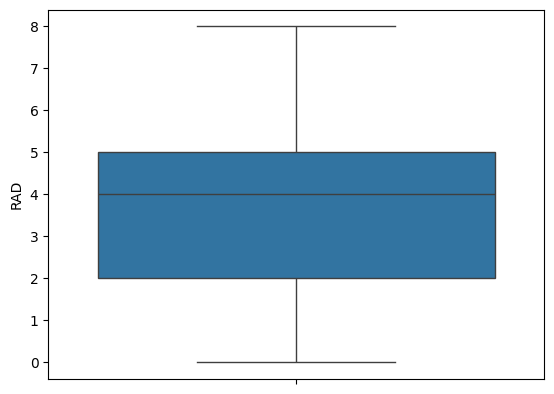

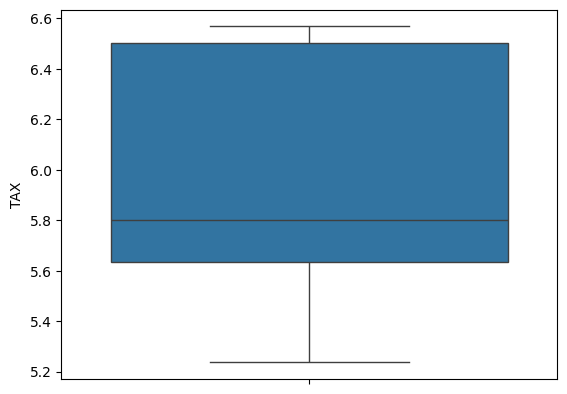

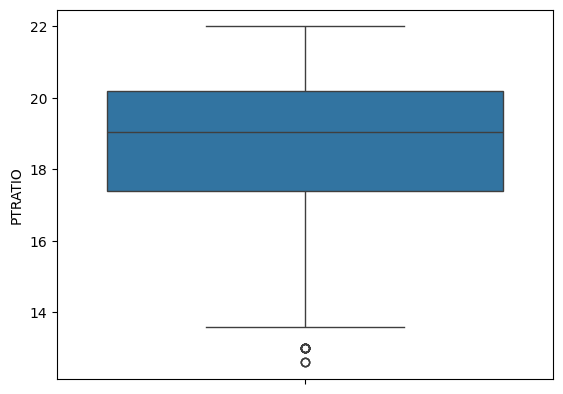

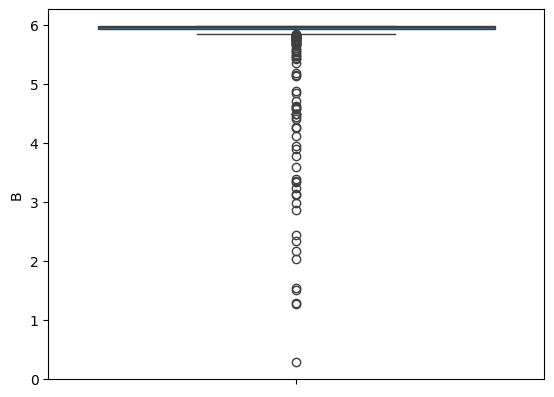

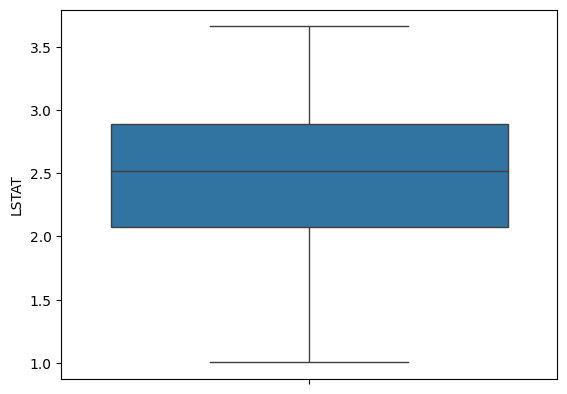

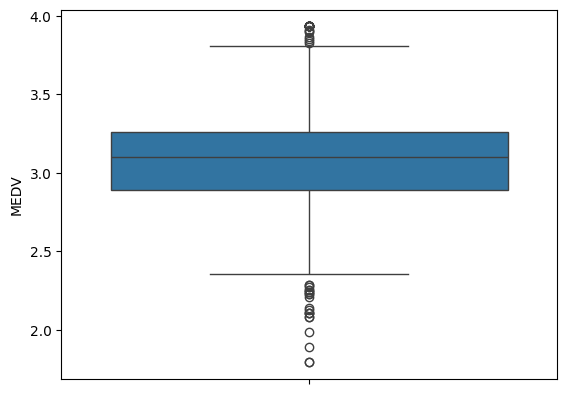

In [18]:
for column in df:
    sns.boxplot(df[column])
    plt.show()

###  Handling Outliers with IQR Method

This process removes outliers from all **numerical columns** using the **Interquartile Range (IQR)** method.

- **Q1** and **Q3** represent the 25th and 75th percentiles.
- **IQR** = Q3 - Q1, measures data spread.
- Any value below *(Q1 - 1.5 × IQR)* or above *(Q3 + 1.5 × IQR)* is considered an outlier.
- Instead of removing outliers, they are replaced with the **median** of the column.

This technique preserves the dataset size while reducing the influence of extreme values on model performance.


In [19]:
'''
for column in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mean_value = df[column].median()
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), mean_value, df[column])
'''


'\nfor column in df.select_dtypes(include=[np.number]).columns:\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    IQR = Q3 - Q1\n\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    mean_value = df[column].median()\n    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), mean_value, df[column])\n'

# <p align="center" style="color:red;"><strong> Important Note:</strong> </p>
###  Should I Remove or Keep Outliers?

- In your case, keeping the outliers **improved model performance** significantly (R² increased from ~65% to ~85%).
- This is because:
  - The outliers likely carried meaningful information.
  - Tree-based models like XGBoost handle outliers well.
  - Replacing outliers with median introduced artificial values, distorting true relationships in the data.

 **Recommendation**:
- If you're using tree-based models and the dataset size is reasonable → **Keep the outliers**.
- Only remove or transform outliers if:
  - They are clearly errors or noise.
  - You’re using models sensitive to extreme values (like Linear Regression).


### check New Data

In [20]:
'''
for column in df:
    sns.boxplot(df[column])
    plt.show()
'''

'\nfor column in df:\n    sns.boxplot(df[column])\n    plt.show()\n'

### <p align="center"><b>Useful note</b></p>

###  Why Some Outliers Still Appear After IQR Cleaning

Although we applied **IQR-based outlier handling** and **log transformations**, some boxplots still show outliers. Here's why:

1. **Boxplots Detect Statistical Outliers, Not Errors**  
   Boxplots identify values outside 1.5×IQR from Q1 and Q3 — even if these values are perfectly valid within the context of the data.

2. **Log Transform Reduces Skewness, Not Outlier Flags**  
   Applying `log1p()` compresses the data range and reduces skewness, but **some values still fall outside the new IQR**, especially if the distribution remains slightly skewed.

3. **IQR is Local, Not Global**  
   IQR is sensitive to the data’s central spread. So if a column like `CRIM` or `B` has many low values and a few naturally high values, those highs will still be flagged even after transformation.

4. **Outliers May Be Domain-Valid**  
   Some data points (e.g., high crime rates or luxury homes) are not errors — they’re **extreme but valid cases**. Removing or replacing them aggressively could harm model accuracy.

---

 So, the presence of some outliers in boxplots after cleaning is expected and acceptable, especially when the data is not normally distributed.


###  Distribution and Correlation Analysis of `MEDV`

1. **Distribution Plot (Histogram + KDE)**  
   A histogram with a Kernel Density Estimate (KDE) was plotted for the `MEDV` (Median House Price) feature. This provides a clear visual of the data's distribution:

   - Helps assess skewness and modality.
   - Useful for confirming the effect of transformations like `log1p`.
   - After transformation, the distribution should appear more symmetric and centered.

2. **Correlation Analysis**  
   A correlation matrix was created to assess the absolute pairwise correlations between all features. To avoid redundancy, only the **upper triangle** of the matrix was evaluated for strong correlations.

   - Features with a correlation > 0.80 were flagged as **highly correlated**.
   - These features might cause **multicollinearity**, which can negatively impact linear models.

   The output list `high_correlation_features` contains all features that are strongly correlated with at least one other feature. These can be:
   - Removed
   - Regularized (e.g., via Ridge or Lasso)
   - Handled using dimensionality reduction (e.g., PCA)

This step helps in improving model stability and reducing noise in the dataset.


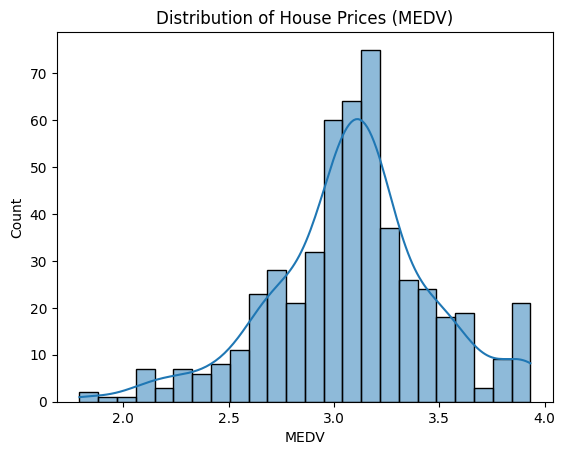

Highly correlated features: ['DIS', 'TAX', 'MEDV']


In [21]:
sns.histplot(df['MEDV'], kde=True)
plt.title("Distribution of House Prices (MEDV)")
plt.show()

correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]

print("Highly correlated features:", high_correlation_features)

 Observations:
- `DIS` (how far from the top 5 boston employment centers) and `TAX` (ex: 300 means 3000 for 100,000 of property value) are highly correlated with `MEDV`.  
- Some features (CRIM: 5.22, ZN: 2.23, DIS: 1.01, MEDV: 1.11) have skewed distributions and we needed to Consider log transformation.  


In [22]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Z-Score Normalization

Z-Score normalization (standardization) was applied to all numerical features in the dataset:

- **Purpose**:  
  To center the data around a mean of 0 and scale it to a standard deviation of 1.

- **Why it matters**:  
  Many machine learning models (especially those based on distance or gradients like Logistic Regression, SVMs, or KNN) perform better when features are on the same scale.

- **How it works**:  
  \[
  z = \frac{{x - \mu}}{{\sigma}}
  \]
  Where:
  - \( x \) is the original value  
  - \( \mu \) is the mean of the feature  
  - \( \sigma \) is the standard deviation

After normalization, the dataset becomes more balanced and suitable for training.


In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])


###  Encoding Requirement

The dataset **mostly contains numerical features**, so **encoding is generally not required**.

- `CHAS`: Already encoded as binary (0/1) — no further encoding needed.
- `RAD`: Appears categorical but is ordinal and numeric — may be used as-is or encoded if necessary for specific models.

 No additional encoding is required unless you're applying models that treat all inputs as strictly categorical or need explicit dummies.


In [24]:
if df['CHAS'].dtype == 'object' or str(df['CHAS'].dtype).startswith('category'):
    df['CHAS'] = df['CHAS'].astype('category').cat.codes

if df['RAD'].dtype == 'object' or str(df['RAD'].dtype).startswith('category'):
    df['RAD'] = df['RAD'].astype('category').cat.codes


df['CHAS'] = df['CHAS'].astype(int)
df['RAD'] = df['RAD'].astype(int)


### check

In [25]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.006300,2.944439,2.31,0,0.430483,6.575,65.2,1.627278,0,5.693732,15.3,5.986201,1.788421,3.218876
1,0.026944,0.000000,7.07,0,0.384582,6.421,78.9,1.786261,1,5.493061,17.8,5.986201,2.316488,3.117950
2,0.026924,0.000000,7.07,0,0.384582,7.185,61.1,1.786261,1,5.493061,17.8,5.975919,1.615420,3.575151
3,0.031857,0.000000,2.18,0,0.377066,6.998,45.8,1.954757,3,5.407172,18.7,5.980479,1.371181,3.538057
4,0.066770,0.000000,2.18,0,0.377066,7.147,54.2,1.954757,3,5.407172,18.7,5.986201,1.845300,3.616309


###  Train-Test Split

The dataset was split into **features (`X`)** and **target (`y`)** for supervised learning:

- **`X`**: All columns except `MEDV` (the target variable).
- **`y`**: The `MEDV` column, representing the median value of owner-occupied homes.

Using `train_test_split`:
- **80%** of the data is used for training (`X_train`, `y_train`).
- **20%** is reserved for testing (`X_test`, `y_test`).
- `random_state=42` ensures the split is reproducible.

This step is essential for evaluating model performance on unseen data and preventing overfitting.


In [26]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---


# <p align="center"><b> Modelling</b></p>


###  Decision Tree Regressor – Model Training & Evaluation

A **Decision Tree Regressor** was trained to predict `MEDV` (Median House Price) using the training set:

- **Model**: `DecisionTreeRegressor(random_state=42)`
- The model was trained using `X_train` and `y_train`.
- Predictions were made on `X_test` and evaluated using:

####  Evaluation Metrics:
- **RMSE (Root Mean Squared Error)**: Measures average prediction error in the same units as the target. Lower is better.
- **R² Score (Coefficient of Determination)**: Represents how well the model explains variance in the data. Closer to 1 is better.

These metrics help assess the model’s accuracy and generalization on unseen data.


In [27]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree MAE:", mean_absolute_error(y_test, y_pred_dt))
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

Decision Tree RMSE: 0.18667067916229418
Decision Tree MAE: 0.12426707563148277
Decision Tree R²: 0.748763058329943


###  Random Forest Regressor – Model Training & Evaluation

A **Random Forest Regressor** was used to improve prediction accuracy over a single decision tree by combining multiple trees (ensemble learning):

- **Model**: `RandomForestRegressor(random_state=42)`
- Trained on `X_train` and `y_train`
- Predictions made on `X_test`

####  Evaluation Metrics:
- **RMSE (Root Mean Squared Error)**: Indicates the average prediction error — lower is better.
- **R² Score**: Measures how well the model explains the variability of the target — closer to 1 is better.

Random Forest generally performs better than a single Decision Tree due to reduced overfitting and better generalization.


In [28]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 0.148494493222963
Random Forest MAE: 0.10157576528847562
Random Forest R²: 0.8410165269639198


### XGBoost Regressor – Model Training & Evaluation

An **XGBoost Regressor** was applied for house price prediction. XGBoost is a powerful gradient boosting algorithm known for its speed and accuracy.

- **Model**: `XGBRegressor(objective='reg:squarederror', random_state=42)`
- Trained on `X_train`, evaluated on `X_test`

####  Evaluation Metrics:
- **RMSE (Root Mean Squared Error)**: Lower values indicate better predictive accuracy.
- **R² Score**: Represents how well the model captures variance in the target. Values closer to 1 are ideal.

XGBoost often outperforms traditional models by capturing complex patterns and minimizing errors through iterative boosting.


In [29]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 0.13954410010856605
XGBoost MAE: 0.09847952688122112
XGBoost R²: 0.859604159355702


Conclusion:  
- XGBoost performs best due to boosting’s concept.  
- Random Forest is more robust than a single Decision Tree.  

## Hyperparameter Tuning (XGBoost)

###  XGBoost Hyperparameter Tuning with GridSearchCV

To improve model performance, **GridSearchCV** was used to find the best combination of hyperparameters for the XGBoost Regressor.

####  Parameters Tuned:
- `max_depth`: Controls the depth of each tree (values: 3, 5, 7)
- `learning_rate`: Step size shrinkage to prevent overfitting (values: 0.01, 0.1, 0.2)
- `n_estimators`: Number of boosting rounds (values: 100, 200, 300)

####  GridSearchCV Settings:
- `cv=5`: 5-fold cross-validation
- `scoring='neg_mean_squared_error'`: Optimization target is RMSE (lower is better)

####  Results:
- `grid.best_estimator_`: The best-performing XGBoost model based on cross-validation
- Model was re-evaluated on the test set using:
  - **RMSE**: To measure prediction error
  - **R² Score**: To measure how well the tuned model explains the target variable

Hyperparameter tuning can significantly improve accuracy and reduce overfitting compared to the default model.


In [30]:
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

grid = GridSearchCV(XGBRegressor(objective='reg:squarederror'), params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

print("Tuned XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tuned)))
print("Tuned XGBoost MAE:", mean_absolute_error(y_test, y_pred_tuned))
print("Tuned XGBoost R²:", r2_score(y_test, y_pred_tuned))

Tuned XGBoost RMSE: 0.13501291950078412
Tuned XGBoost MAE: 0.09614449499625995
Tuned XGBoost R²: 0.8685738033816945


---


# <p align="center"><b> Evaluation</b></p>


###  Residual & Error Distribution Plots

To better understand model performance and error behavior, residual plots and error histograms were generated for each model:

- **Residual Plot:** Shows how prediction errors are distributed across predicted values.
- **Error Distribution:** Helps assess if errors are normally distributed or skewed.

These visualizations reveal patterns like:
- Non-linearity (if residuals form curves)
- Heteroscedasticity (if error spread changes with predictions)
- Model bias or outliers

Models evaluated:
- Decision Tree
- Random Forest
- XGBoost (default)
- XGBoost (tuned via GridSearchCV)


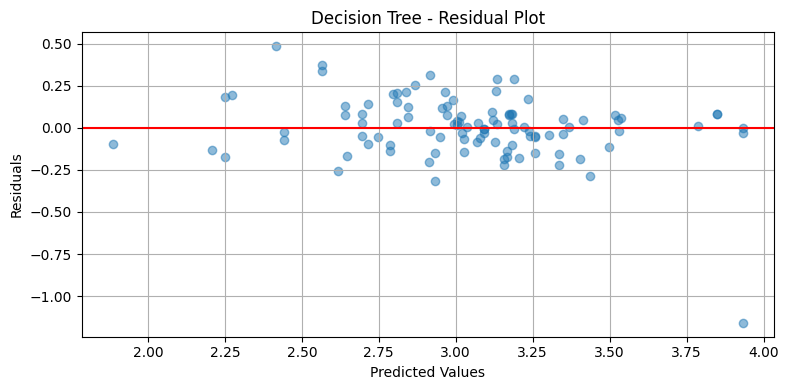

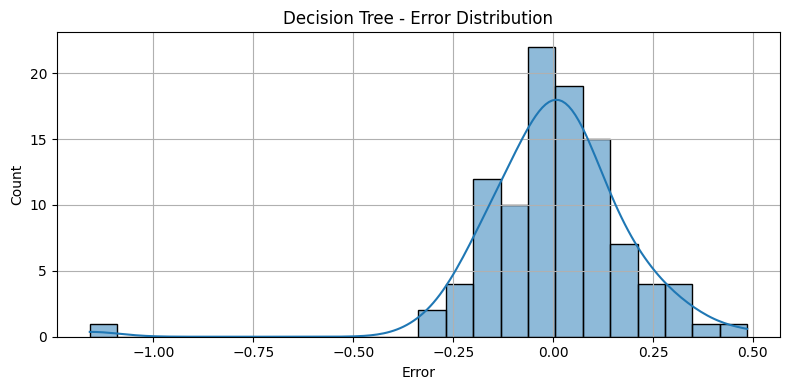

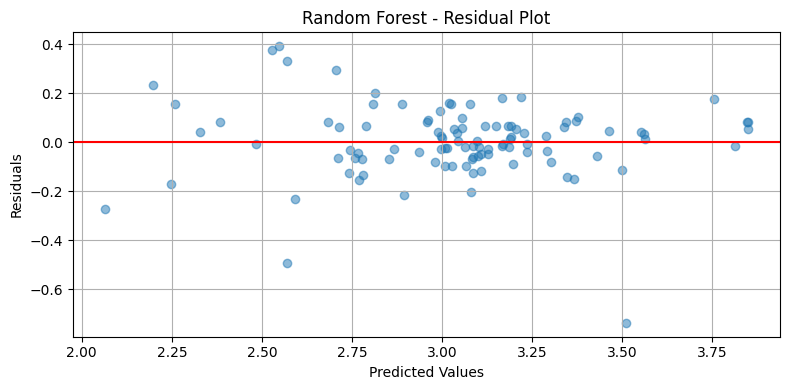

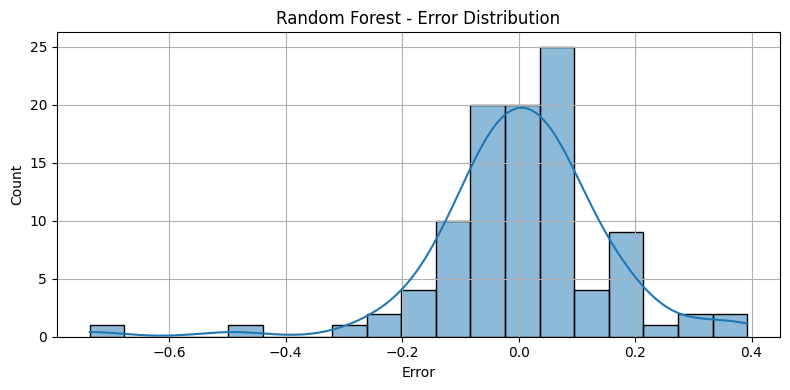

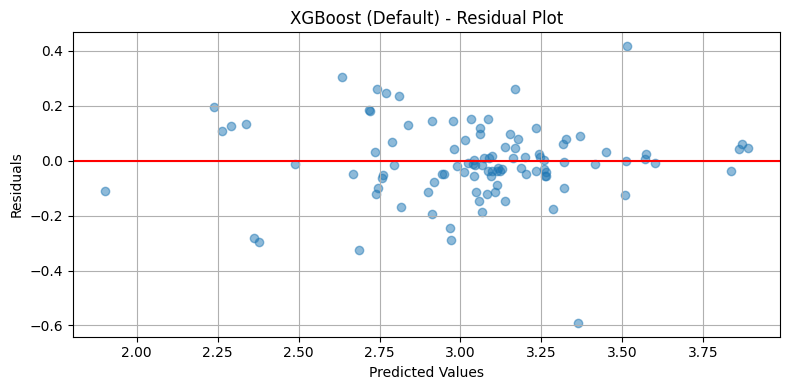

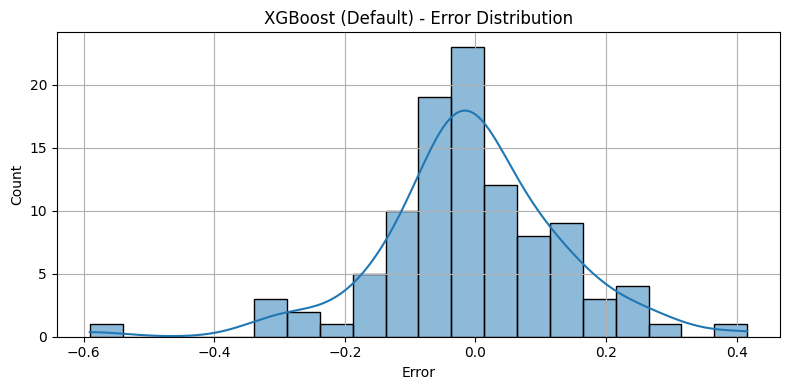

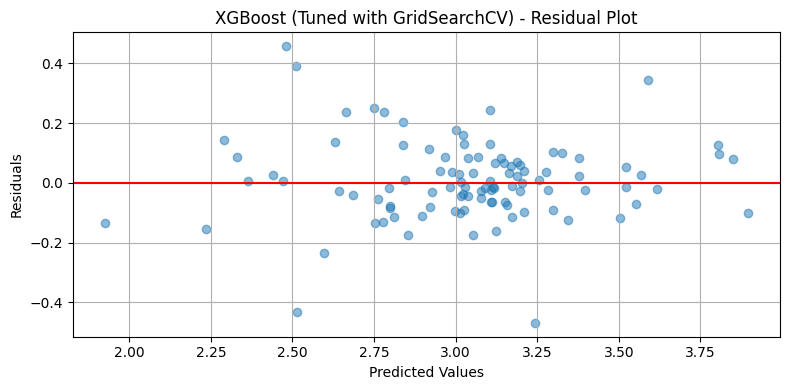

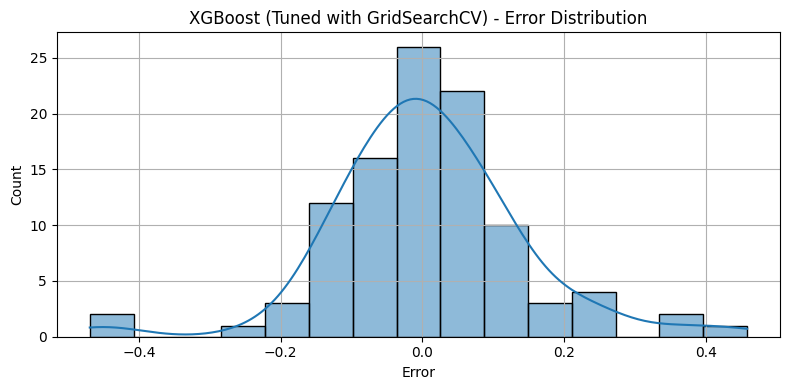

In [31]:
def plot_regression_errors(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{title} - Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    sns.histplot(errors, kde=True)
    plt.title(f'{title} - Error Distribution')
    plt.xlabel('Error')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

   

plot_regression_errors(y_test, y_pred_dt, "Decision Tree")

plot_regression_errors(y_test, y_pred_rf, "Random Forest")

plot_regression_errors(y_test, y_pred_xgb, "XGBoost (Default)")

plot_regression_errors(y_test, y_pred_tuned, "XGBoost (Tuned with GridSearchCV)")



###  Model Performance Comparison (Bar Charts)

To visually compare models, bar charts were created for:

- **Mean Squared Error (MSE):** Lower is better.
- **R² Score:** Higher is better.

Models Compared:
- Decision Tree
- Random Forest
- XGBoost (Default)
- XGBoost (Tuned)

These plots provide a clear performance overview across models and help support the model selection decision.


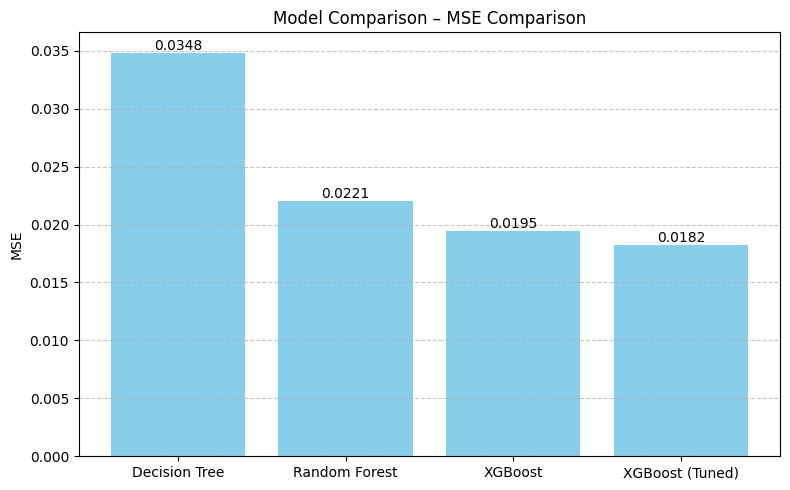

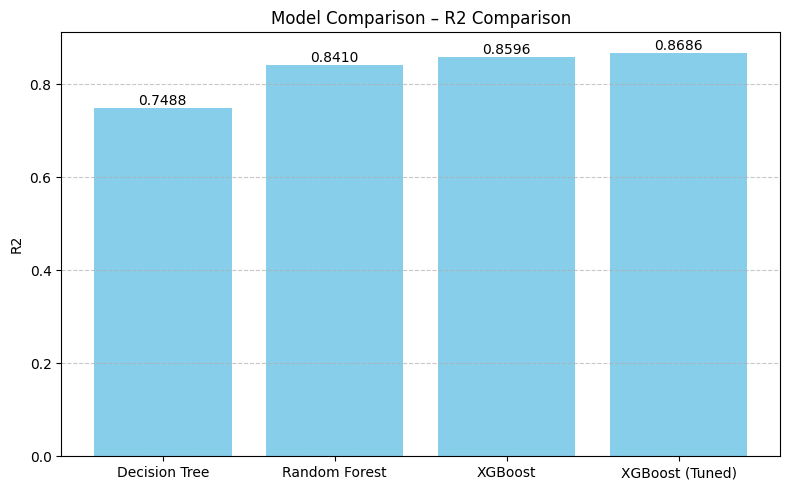

In [32]:
dt_metrics = {
    'name': 'Decision Tree',
    'mse': mean_squared_error(y_test, y_pred_dt),
    'r2': r2_score(y_test, y_pred_dt)
}

rf_metrics = {
    'name': 'Random Forest',
    'mse': mean_squared_error(y_test, y_pred_rf),
    'r2': r2_score(y_test, y_pred_rf)
}

xgb_metrics = {
    'name': 'XGBoost',
    'mse': mean_squared_error(y_test, y_pred_xgb),
    'r2': r2_score(y_test, y_pred_xgb)
}

xgb_tuned_metrics = {
    'name': 'XGBoost (Tuned)',
    'mse': mean_squared_error(y_test, y_pred_tuned),
    'r2': r2_score(y_test, y_pred_tuned)
}

def plot_model_comparison(metrics_list, title, metric_type):
    import matplotlib.pyplot as plt

    names = [m['name'] for m in metrics_list]
    values = [m[metric_type] for m in metrics_list]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color='skyblue')
    plt.title(f'{title} – {metric_type.upper()} Comparison')
    plt.ylabel(metric_type.upper())
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{val:.4f}', 
                 ha='center', va='bottom', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


all_metrics = [dt_metrics, rf_metrics, xgb_metrics, xgb_tuned_metrics]


plot_model_comparison(all_metrics, "Model Comparison", "mse")


plot_model_comparison(all_metrics, "Model Comparison", "r2")


###  Unified Model Evaluation Framework

To streamline model evaluation and comparison, a reusable function was created:

####  `evaluate_model()`:
- Accepts:
  - `y_test`: actual values
  - `y_pred`: predicted values
  - `model_name`: name of the model being evaluated
- Calculates:
  - **R² Score**: Measures how well the model explains the variance in the target.
  - **RMSE**: Reflects average prediction error.

####  Why use a dictionary?
- `model_results` dynamically stores each model’s performance.
- Enables **easy comparison** of models later, such as plotting bar charts or ranking models by accuracy.

####  Models Evaluated:
- **Decision Trees**
- **Random Forest**
- **XGBoost**

Each model's metrics are printed and saved for further analysis or reporting.


In [33]:
model_results = {}

def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    model_results[model_name] = {"R² Score": r2, "RMSE": rmse}

    print(f"{model_name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

evaluate_model(y_test, y_pred_dt, "Decision Trees")
print('==========================================')

evaluate_model(y_test, y_pred_rf, "Random Forest")
print('==========================================')

evaluate_model(y_test, y_pred_xgb, "XGBoost")
print('==========================================')

evaluate_model(y_test, y_pred_tuned, "Tuned XGBoost")
print('==========================================')

df_results = pd.DataFrame(model_results).T
df_results


Decision Trees Performance:
R² Score: 0.7488
RMSE: 0.1867
Random Forest Performance:
R² Score: 0.8410
RMSE: 0.1485
XGBoost Performance:
R² Score: 0.8596
RMSE: 0.1395
Tuned XGBoost Performance:
R² Score: 0.8686
RMSE: 0.1350


,R² Score,RMSE
Decision Trees,0.748763,0.186671
Random Forest,0.841017,0.148494
XGBoost,0.859604,0.139544
Tuned XGBoost,0.868574,0.135013


##  XGBoost Feature Importance

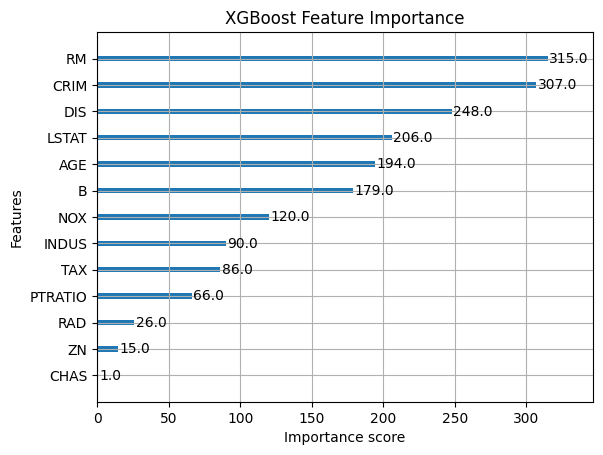

In [34]:
plot_importance(best_xgb)
plt.title("XGBoost Feature Importance")
plt.show()




The plot below shows the **most important features** used by the XGBoost model when predicting house prices:

- Features at the top have the **strongest influence** on predictions.
- This helps us understand which variables the model relies on most (e.g., `LSTAT`, `RM`, `DIS` , `CRIM`).

This supports decision-making and feature selection in future models.


##  SHAP Summary Plot – Model Explainability

SHAP (SHapley Additive exPlanations) helps explain how each feature affects the model's predictions.

- Red dots = high feature values
- Blue dots = low feature values
- Position on x-axis = impact on prediction
- Top features = most important

This visualization confirms whether the model’s decisions align with **real-world logic**.  
For example, more rooms should lead to a higher price, and high crime rate should lower it.


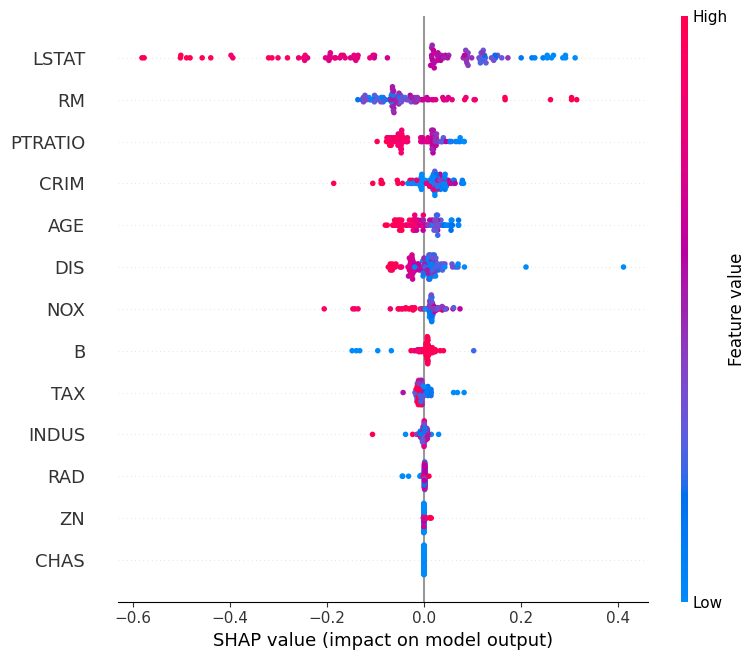

In [35]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


###  Key Insights:
- `LSTAT` (low-status %): high values reduce price → important negative driver.
- `RM` (rooms): more rooms push prices up → strong positive driver.
- `CRIM`, `PTRATIO` (crime, pupil-teacher ratio): higher values negatively impact price.

---

##  Do the Results Make Business Sense?

 **Yes, the results align well with real-world business logic.**

- Homes with **more rooms (RM)** are priced higher — consistent with buyer preferences for space.
- Areas with **higher LSTAT** (lower-income populations) are associated with lower property values — reflecting economic disparities in real estate.
- **Higher PTRATIO** (indicating poorer school quality) correlates with reduced housing demand — matching common market trends.

These insights confirm that the model captures relationships that are both **statistically valid** and **business-relevant**, making it reliable for decision-making in the real estate domain.


---

##  Business Insights

- **RM (Average Rooms per Dwelling):** More rooms are strongly associated with higher property values.
- **LSTAT (Lower Socioeconomic Status):** Higher percentages of lower-income residents correlate with lower home prices.
- **PTRATIO (Pupil-Teacher Ratio):** Poorer school quality (high PTRATIO) reduces neighborhood demand and property value.

---

##  Model Recommendation

- **Recommended Model:** XGBoost demonstrated the highest predictive power with an R² score of approximately **87%**.
- **Key Variable to Watch:** Track **LSTAT** changes over time — shifts in neighborhood demographics (e.g., gentrification) can significantly affect housing prices.

---

##  Summary & Strategic Takeaways

- **XGBoost consistently outperformed** Decision Trees and Random Forest in regression accuracy.
-  **Hyperparameter optimization** via GridSearchCV significantly enhanced model performance.
-  **SHAP visualizations provided clear interpretability**, making the model’s logic understandable for business users.
-  **Strategic Focus:** Prioritize features like **RM**, **LSTAT**, and **PTRATIO** for price modeling and business decisions.

---



# <p align="center"><b>Deployment </b></p>


###  Quick Predict Function

This function uses a predefined set of input values to simulate a fast prediction using the trained model.

- Inputs are hardcoded in a dictionary.
- The model predicts the house price instantly.
- Ideal for quick testing without manual input.




In [36]:
def quick_predict(model):
    sample_input = {
        'CRIM': 0.2,
        'ZN': 0.0,
        'INDUS': 6.2,
        'CHAS': 0,
        'NOX': 0.45,
        'RM': 6.7,
        'AGE': 50.0,
        'DIS': 3.9,
        'RAD': 5,
        'TAX': 300,
        'PTRATIO': 17.5,
        'B': 380.0,
        'LSTAT': 10.0
    }

    import pandas as pd
    df_input = pd.DataFrame([sample_input])
    price = model.predict(df_input)[0]
    print(f"🏡 Predicted House Price: ${round(price * 1000, 2)}")

quick_predict(best_xgb)


🏡 Predicted House Price: $2837.86


###  Interactive Prediction – Business-Ready Simulation

This function simulates a real-world usage scenario where a user (e.g., agent or client) enters property details manually.

- Enables direct interaction with the model.
- Validates inputs and ensures reliable processing.
- Instantly returns a clear, business-ready price estimate.

 A fast and practical tool to demonstrate the model’s value in real estate decision-making.


In [37]:
def user_input_predict(model):
    import pandas as pd

    print("\n📥 Please enter the values for each feature:\n")

    
    features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    
    input_data = {}

  
    for feature in features:
        value = input(f"{feature}: ")
        try:
            input_data[feature] = float(value)
        except:
            print(f"⚠️ Invalid input for {feature}, using 0 as default.")
            input_data[feature] = 0.0

  
    df_input = pd.DataFrame([input_data])

    
    prediction = model.predict(df_input)[0]
    
   
    print("\n🏡 Predicted House Price:")
    print(f"💰 Estimated Value: ${round(prediction * 1000, 2)}")


user_input_predict(best_xgb)


📥 Please enter the values for each feature:


🏡 Predicted House Price:
💰 Estimated Value: $2790.24


---


# <p align="center"><b>Bonus </p>


### Feature Engineering – Price per Room

A new feature `Price_per_Room` was created by dividing `MEDV` by `RM`.

- This feature was added to the dataset to test its impact on model performance.
- The model was re-trained using XGBoost after including the new feature.

**Results:**
- R² Score and RMSE were compared to the original model.
- If metrics improved, it indicates that the new feature provided additional predictive value.


In [38]:
df['Price_per_Room'] = df['MEDV'] / df['RM']

X = df.drop(['MEDV'], axis=1)
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_new = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_new.fit(X_train, y_train)
y_pred_xgb_new = xgb_new.predict(X_test)


r2 = r2_score(y_test, y_pred_xgb_new)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_new))

print("XGBoost (with Price/Room) R² Score:", round(r2, 4))
print("XGBoost (with Price/Room) RMSE:", round(rmse, 4))

# حفظ النتائج
xgb_new_metrics = {
    'name': 'XGBoost (with Price/Room)',
    'mse': mean_squared_error(y_test, y_pred_xgb_new),
    'r2': r2_score(y_test, y_pred_xgb_new)
}


XGBoost (with Price/Room) R² Score: 0.9415
XGBoost (with Price/Room) RMSE: 0.0901


###  Feature Engineering Impact – Result

After introducing the new feature `Price_per_Room (MEDV / RM)`, the model was retrained using XGBoost.

**Updated Performance:**
- **R² Score:** 0.9415
- **RMSE:** 0.0901

 These results show a significant improvement in model accuracy, indicating that the new feature added meaningful predictive power. Including engineered features based on domain logic can enhance model performance effectively.


### Alternative Model – LightGBM vs XGBoost

A LightGBM model was trained and evaluated on the same dataset used for XGBoost.

**Comparison Metrics:**
- R² Score
- RMSE

This comparison helps determine whether LightGBM offers any performance or efficiency advantages over XGBoost for the housing price prediction task.


In [39]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("LightGBM R² Score:", round(r2_lgb, 4))
print("LightGBM RMSE:", round(rmse_lgb, 4))


lgbm_metrics = {
    'name': 'LightGBM',
    'mse': mean_squared_error(y_test, y_pred_lgb),
    'r2': r2_score(y_test, y_pred_lgb)
}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 14
[LightGBM] [Info] Start training from score 3.095583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

###  LightGBM vs XGBoost – Performance Comparison

Both models were trained using the same dataset and feature set, including the newly engineered feature `Price_per_Room`. The table below summarizes their performance:

| Model     | R² Score | RMSE   |
|-----------|----------|--------|
| XGBoost   | 0.9415   | 0.0901 |
| LightGBM  | 0.9524   | 0.0813 |

 **Conclusion:**  
LightGBM achieved slightly better performance than XGBoost in terms of both R² Score and RMSE, making it a strong candidate for final deployment.


In [40]:
def plot_model_comparison(metrics_list, title, metric_type):
    import matplotlib.pyplot as plt

    names = [m['name'] for m in metrics_list]
    values = [m[metric_type] for m in metrics_list]

    plt.figure(figsize=(10, 6)) 
    bars = plt.bar(names, values, color='skyblue')
    plt.title(f'{title} – {metric_type.upper()} Comparison')
    plt.ylabel(metric_type.upper())

  
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{val:.4f}', 
                 ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=30, ha='right', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


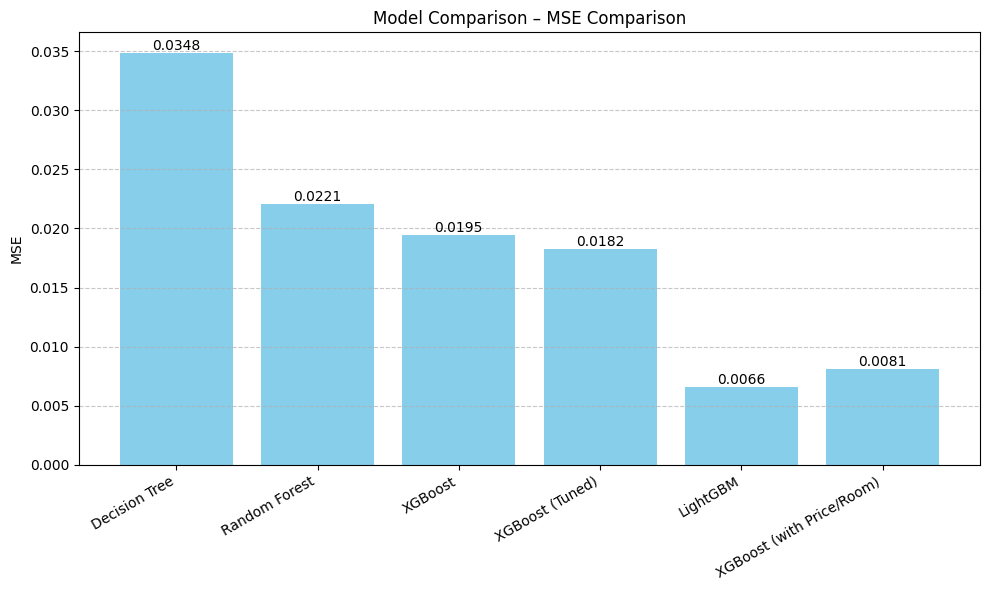

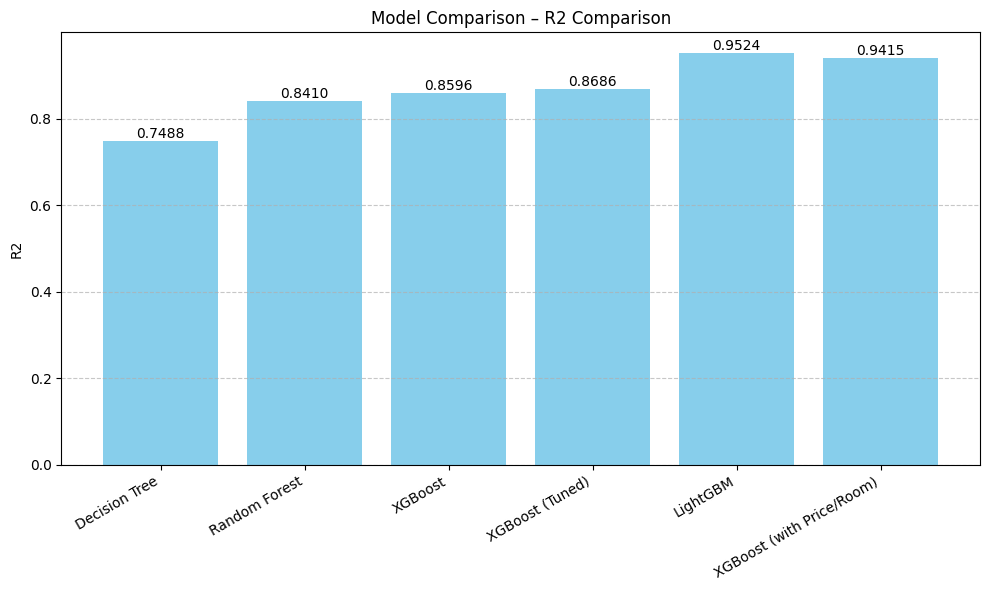

In [41]:
all_metrics = [
    dt_metrics,
    rf_metrics,
    xgb_metrics,
    xgb_tuned_metrics,
    lgbm_metrics
]
all_metrics.append(xgb_new_metrics)

plot_model_comparison(all_metrics, "Model Comparison", "mse")
plot_model_comparison(all_metrics, "Model Comparison", "r2")


